In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('Corona_NLP_train.csv')

test = pd.read_csv('Corona_NLP_test.csv')


In [3]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


[Text(0.5, 0, 'Sentiment Distribution for Test'), Text(0, 0.5, 'Tweet Count')]

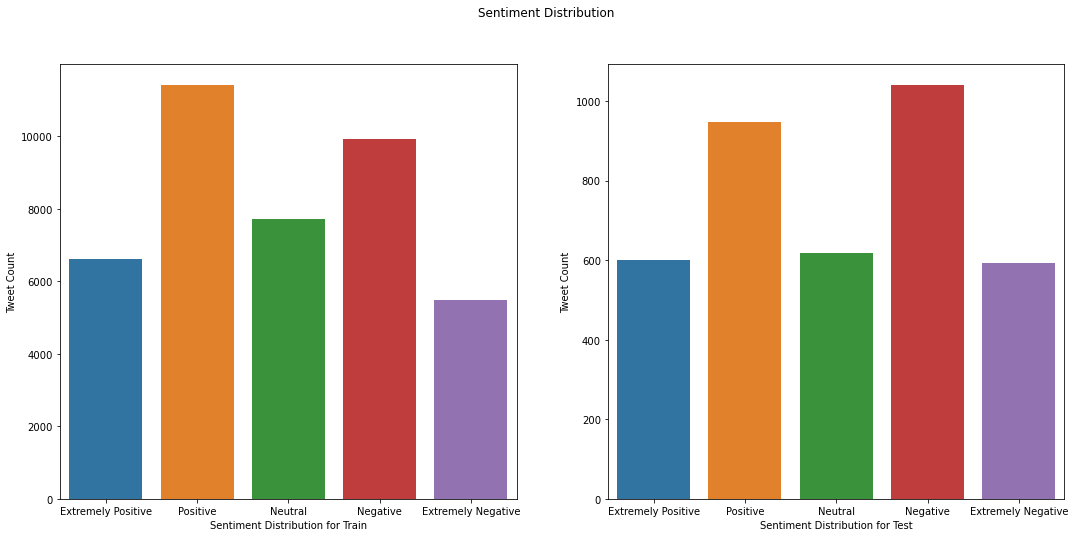

In [5]:
f, axes = plt.subplots(1,2,figsize=(18,8))
f.suptitle("Sentiment Distribution")
axes[0] = sns.countplot(ax=axes[0], data=train, x='Sentiment', order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'])
axes[0].set(xlabel='Sentiment Distribution for Train', ylabel='Tweet Count')
axes[1] = sns.countplot(ax=axes[1], data=test, x='Sentiment', order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'])
axes[1].set(xlabel='Sentiment Distribution for Test', ylabel='Tweet Count')

In [6]:
lemmatizer = WordNetLemmatizer()
def preprocessing(dataset):
    corpus = []
    for i in range(0, len(dataset)):
        tweet = re.sub('[^a-zA-Z]',' ', dataset['OriginalTweet'][i])
        tweet = tweet.lower()
        tweet = tweet.split()
        tweet = [lemmatizer.lemmatize(word, pos='v') for word in tweet if not word in stopwords.words('english')]
        tweet = ' '.join(tweet)
        corpus.append(tweet)
    
    return corpus

In [7]:
train_corpus = preprocessing(train)
test_corpus = preprocessing(test)

In [8]:
train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [9]:
map_sentiment = {'Extremely Positive':0, 'Positive':1, 'Neutral':2, 'Negative':3, 'Extremely Negative':4}
y_train = to_categorical(train['Sentiment'].map(map_sentiment), 5)
y_test = to_categorical(test['Sentiment'].map(map_sentiment), 5)
y_train

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
maxlen = 0
count = []
for x in train_corpus:
    if(len(x.split())>maxlen):
        maxlen = len(x.split())
        count.append(len(x.split()))

print("Maximum words in a sentence is:", maxlen)

Maximum words in a sentence is: 50


<AxesSubplot:ylabel='Count'>

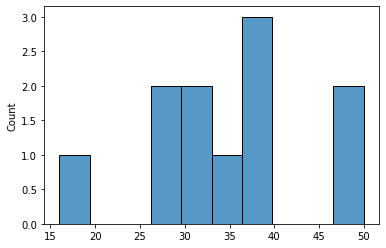

In [11]:
sns.histplot(data=count, bins=10)

In [25]:
sent_length = 50
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(train_corpus)
vocab_size = len(t.word_index) + 1

train_encoded = t.texts_to_sequences(train_corpus)
test_encoded = t.texts_to_sequences(test_corpus)

train_embedded_docs = pad_sequences(train_encoded, padding='pre', maxlen=sent_length)
test_embedded_docs = pad_sequences(test_encoded, padding='pre', maxlen=sent_length)

In [26]:

embedding_vector_features = 32
model = Sequential()
model.add(layers.Embedding(vocab_size, output_dim=embedding_vector_features, input_length=sent_length, mask_zero=True))
model.add(layers.LSTM(100))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 32)            2385120   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total params: 2,445,109
Trainable params: 2,445,109
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history = model.fit(train_embedded_docs, 
                    y_train,
                   validation_data=(test_embedded_docs, y_test),
                   epochs=10,
                   batch_size=64,
                   )

Epoch 1/10
644/644 [==============================] - 88s 127ms/step - loss: 1.0974 - accuracy: 0.5434 - val_loss: 0.8810 - val_accuracy: 0.6646
Epoch 2/10
644/644 [==============================] - 81s 125ms/step - loss: 0.6064 - accuracy: 0.7805 - val_loss: 0.8740 - val_accuracy: 0.6854
Epoch 3/10
644/644 [==============================] - 81s 125ms/step - loss: 0.3846 - accuracy: 0.8692 - val_loss: 1.0248 - val_accuracy: 0.6677
Epoch 4/10
644/644 [==============================] - 81s 125ms/step - loss: 0.2595 - accuracy: 0.9124 - val_loss: 1.1755 - val_accuracy: 0.6606
Epoch 5/10
644/644 [==============================] - 81s 125ms/step - loss: 0.1906 - accuracy: 0.9376 - val_loss: 1.5495 - val_accuracy: 0.6332
Epoch 6/10
644/644 [==============================] - 81s 126ms/step - loss: 0.1463 - accuracy: 0.9523 - val_loss: 1.4707 - val_accuracy: 0.6353
Epoch 7/10
644/644 [==============================] - 81s 126ms/step - loss: 0.1150 - accuracy: 0.9623 - val_loss: 1.7694 - val_ac